In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'


num GPUs 0


# 1. Load a test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 128, 128)


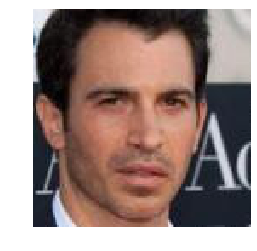

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '5' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    #img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
    cx=89
    cy=121
    img_pil = img_pil.crop((cx-64, cy - 64, cx + 64, cy+64))

img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)


img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')

save_path= 'Original'+'_'+img_name+'.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches = 0)

img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

# normalize the pixels to [-1,1]
img_var = 2*img_var -1



# 2. Compressed sensing using generative models

## 2.1. Load a pretrained generative model on the dataset (now: PGGAN)

In [3]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG
#G.eval()
mse = torch.nn.MSELoss()

Using cache found in /home/vanhoan310/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


## 2.2. A=I

In [ ]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100, factor=0.8):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [ ]:
print(torch.min(img_var), torch.max(img_var))

In [ ]:
#z_hat = fit(G = G, latentDim = model.config.noiseVectorDim, y= img_var, num_iter = 1600, lr_decay_epoch = 400)    
'''z_hat, mse_wrt_truth = CSGM(G=G, 
             latentDim = model.config.noiseVectorDim, 
             y=img_var, 
             device = device,
             num_iter=1600)
gen_image = G(z_hat)

grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

plt.show()
'''

In [ ]:
'''plt.xlabel('optimizer iteration')
plt.ylabel('recovery error')
plt.semilogy(mse_wrt_truth)'''

## 2.3. A= Gaussian 

In [4]:
f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)

# random Gaussian measurement process

A = torch.randn(m_image, d_image).to(device)
x = img_var.to(device).reshape(d_image)
y = torch.matmul(A,x).to(device)

#latentDim = model.config.noiseVectorDim
print(A.shape, x.shape, y.shape)

Compression rate is  0.2
Number of measurements is  9830  for signal of length  49152
torch.Size([9830, 49152]) torch.Size([49152]) torch.Size([9830])


Running CSGM:
CSGM step 0/1600, objective = 136.58591
CSGM step 50/1600, objective = 44.38677
CSGM step 100/1600, objective = 35.76349
CSGM step 150/1600, objective = 33.24734
CSGM step 200/1600, objective = 29.47489
CSGM step 250/1600, objective = 26.66904
CSGM step 300/1600, objective = 31.28903
CSGM step 350/1600, objective = 22.20822
CSGM step 400/1600, objective = 21.47267
CSGM step 450/1600, objective = 19.36303
CSGM step 500/1600, objective = 19.41479
CSGM step 550/1600, objective = 19.10525
CSGM step 600/1600, objective = 19.37408
CSGM step 650/1600, objective = 18.07446
CSGM step 700/1600, objective = 17.96925
CSGM step 750/1600, objective = 17.91100
CSGM step 800/1600, objective = 18.89456
CSGM step 850/1600, objective = 19.40395
CSGM step 900/1600, objective = 17.75061
CSGM step 950/1600, objective = 16.42405
CSGM step 1000/1600, objective = 17.10315
CSGM step 1050/1600, objective = 17.46227
CSGM step 1100/1600, objective = 16.00199
CSGM step 1150/1600, objective = 17.47424


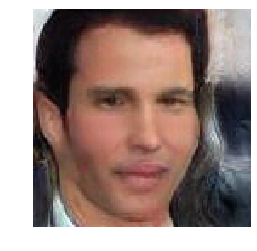

In [5]:
t0= time.time()
latentDim = model.config.noiseVectorDim
z_hat, mse_wrt_loss = CSGM2(G, latentDim, y, A, device, num_iter = 1600)
x_hat = G(z_hat)

grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

save_path= 'PGGAN'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 
    
t1= time.time()
print('\nTime elapsed:',t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

# 3. Compressed Sensing using Deep decoder

## 3.1. Define the network

In [6]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)



n_scales= 5 num_channels_up= [120, 40, 20, 15, 10]
number of parameters:  13110
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

## 3.2. CS using untrained network

In [7]:
def fit3(net, num_channels, d_image, y, A, device, num_iter = 8000, lr_decay_epoch = 2000):
    # compute the size of (fixed) latent vector and draw it uniformly  
    totalupsample = 2**(len(num_channels)-1)
    w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
    width = int(w/(totalupsample))
    height = int(w/(totalupsample))

    shape = [1,num_channels[0], width, height]  
    print("shape of latent code B1: ", shape)

    print("initializing latent code B1...")
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()

    #x_in = net(net_input.type(dtype)).data.clone() #initializing image

    # processing optimization
    if decodetype=='upsample':
        p = [x for x in net.decoder.parameters() ] #list of all weigths
    elif decodetype=='transposeconv':
        p = [x for x in net.convdecoder.parameters() ] #list of all weigths

    optimizer = torch.optim.Adam(p, lr=0.0002)
    mse = torch.nn.MSELoss()
    m_image = y.numel()
    
    for i in range(num_iter):

        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.0002, lr_decay_epoch=lr_decay_epoch,factor=0.8)

        #################
        def closure():
            optimizer.zero_grad()           
            x_np = net(net_input.type(dtype)).to(device)
            x_var = 2*x_np-1
            
            #y_var = x_var
            y_var = torch.matmul(A,x_var.reshape(d_image))
            
            loss = mse(y_var, y) #torch.matmul(A,x_hat)
            loss.backward()
            #mse_wrt_truth[i] = loss.data.cpu().numpy()
            
            return loss

        loss = optimizer.step(closure) 
        if i %100 == 0:
            print ('Iteration %05d   Train loss %f ' % (i, loss.item()/np.sqrt(m_image) ))
        #print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

    return net, net_input, loss

shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...

Learning rate is set to 0.0002


Iteration 00000   Train loss 190.430736 
Iteration 00100   Train loss 70.674583 
Iteration 00200   Train loss 49.167144 
Iteration 00300   Train loss 37.194671 
Iteration 00400   Train loss 29.458780 
Iteration 00500   Train loss 24.101215 
Iteration 00600   Train loss 20.003158 
Iteration 00700   Train loss 16.934919 
Iteration 00800   Train loss 14.678759 
Iteration 00900   Train loss 13.002282 
Iteration 01000   Train loss 11.838831 
Iteration 01100   Train loss 10.913803 
Iteration 01200   Train loss 10.206114 
Iteration 01300   Train loss 9.663375 
Iteration 01400   Train loss 9.203164 
Iteration 01500   Train loss 8.833176 
Iteration 01600   Train loss 8.545709 
Iteration 01700   Train loss 8.308524 
Iteration 01800   Train loss 8.059931 
Iteration 01900   Train loss 7.858865 

Learning rate is set to 0.00016


Iteration 02000   Train loss 7.676680 
Iteration 02100   Train lo

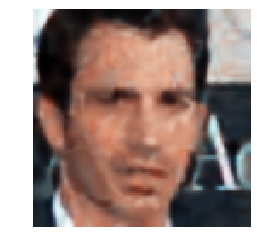

In [8]:
t0 = time.time()

net, net_input, loss = fit3(net, num_channels, d_image, y=y, A=A, device= device,
                            num_iter = 6000, lr_decay_epoch=2000)
x_hat = net( net_input.type(dtype) )#.data.cpu().numpy()[0]

t1 = time.time()
grid = torchvision.utils.make_grid(x_hat, scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
#plt.imshow(x_hat.transpose(1,2,0))
#plt.show()

print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

save_path= 'DD'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0)


# 4. Compressed sensing using hybrid model

## 4.1. Define the untrained network used for hybrid model

In [9]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

n_scales= 5 num_channels_up= [120, 40, 20, 15, 10]
number of parameters:  13110
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

In [10]:
def fit4(G, net, num_channels, d_image, y, z_0, latentDim, num_iter = 1000, lr_decay_epoch = 0):
    G.eval()
    z = torch.normal(torch.zeros(1,latentDim)) #.to(config.device)
    z = Variable(z, requires_grad = True)
    
    
    # compute the size of (fixed) latent vector and draw it uniformly  
    totalupsample = 2**(len(num_channels)-1)
    w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
    width = int(w/(totalupsample))
    height = int(w/(totalupsample))

    shape = [1,num_channels[0], width, height]  
    print("shape of latent code B1: ", shape)

    print("initializing latent code B1...")
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    
    # collecting all trainable parameters
    alpha_init = torch.zeros(1)
    beta_init = torch.zeros(1)
    alpha_init.data[0] = 0.5
    beta_init.data[0] = 0.5

    alpha = Variable(alpha_init, requires_grad=True)
    beta = Variable(beta_init, requires_grad=True)
    
    if decodetype=='upsample':
        p = [x for x in net.decoder.parameters() ] #list of all weigths
    elif decodetype=='transposeconv':
        p = [x for x in net.convdecoder.parameters() ] #list of all weigths
    
    
    
    #weight_decay = 0
    #optimizer = torch.optim.Adam(p, lr=0.001)
    
    optimizer = torch.optim.Adam(
    [
        {"params": p, "lr": 0.0001},
        {"params": alpha, "lr": 0.01},
        {"params": beta, "lr": 0.01},
        {"params": z, "lr": 0.1}
    ],
)
    
    mse = torch.nn.MSELoss()
    
    for i in range(num_iter):

        #################
        #if lr_decay_epoch is not 0:
        #    optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.001, lr_decay_epoch=lr_decay_epoch,factor=0.8)

        #################
        def closure():
            optimizer.zero_grad()           
            alpha_clamp = alpha.clamp(0,1)
            beta_clamp = beta.clamp(0,1)
            
            x_var = alpha_clamp*G(z) + beta_clamp*(2*net(net_input.type(dtype))-1)
            #y_hat = x_hat
            
            y_var = torch.matmul(A,x_var.reshape(d_image))
            loss = mse(y_var, y) #torch.matmul(A,x_hat)
            loss.backward()
            #mse_wrt_truth[i] = loss.data.cpu().numpy()
            return loss

        loss = optimizer.step(closure) 
        if i % 100 == 0:
            print ('Iteration %04d   Train loss %f ' % (i, loss.detach().cpu().numpy()))

    return net, net_input, z, alpha, beta, loss

## 4.2. CS using hybrid model

Running CSGM:
CSGM step 0/600, objective = 316.30376
CSGM step 50/600, objective = 64.35728
CSGM step 100/600, objective = 52.37083
CSGM step 150/600, objective = 45.38783
CSGM step 200/600, objective = 37.18405
CSGM step 250/600, objective = 31.42828
CSGM step 300/600, objective = 26.56172
CSGM step 350/600, objective = 23.71849
CSGM step 400/600, objective = 21.41341
CSGM step 450/600, objective = 21.42760
CSGM step 500/600, objective = 19.98763
CSGM step 550/600, objective = 19.52474
shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...
Iteration 0000   Train loss 14270.139648 
Iteration 0100   Train loss 3370.691650 
Iteration 0200   Train loss 2345.302734 
Iteration 0300   Train loss 1863.309814 
Iteration 0400   Train loss 1600.858398 
Iteration 0500   Train loss 1416.393188 
Iteration 0600   Train loss 1277.494019 
Iteration 0700   Train loss 1266.625977 
Iteration 0800   Train loss 1096.922485 
Iteration 0900   Train loss 1023.856384 
tensor([0.7018], requires

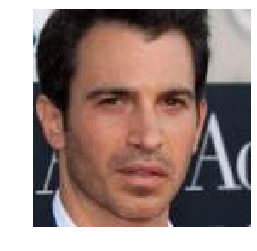

In [11]:
t0 = time.time()
z0, mse_wrt_truth = CSGM2(G=G, latentDim=latentDim, y=y, A=A, device=device, num_iter=600)

x0 = G(z0)

#grid = torchvision.utils.make_grid(x0.clamp(min=-1, max=1), scale_each=True, normalize=True)
#plt.axis('off')
#plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

net, net_input, z, alpha, beta, loss = fit4(G, net, num_channels, d_image, y, z_0 = z0, 
                                            latentDim=latentDim, num_iter = 1000, lr_decay_epoch = 0)

x_hat = alpha.clamp(0,1)*G(z) + beta.clamp(0,1)*(2*net(net_input.type(dtype)) - 1)

print(alpha,beta)

grid = torchvision.utils.make_grid(img_var, scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

t1 = time.time()
print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var)
print('\nl2-recovery error:', error_wrt_truth)


save_path= 'Hybrid'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 